##### Task 2: Text Chunking, Embedding, and Vector Store Indexing

This notebook implements:
1. Text chunking strategy for long narratives
2. Embedding generation using sentence transformers
3. Vector store creation and indexing with FAISS
4. Metadata preservation for traceability

##### Load Preprocessed Data

In [4]:
# Load the filtered dataset from Task 1
import pandas as pd
df = pd.read_csv('../data/filtered_complaints.csv')

print(f"Loaded dataset with {len(df)} complaints")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
print(df.head())

Loaded dataset with 248617 complaints
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narrative_length']

Sample data:
  Date received                      Product  \
0    2025-06-13                  Credit card   
1    2025-06-13  Checking or savings account   
2    2025-06-12                  Credit card   
3    2025-06-12                  Credit card   
4    2025-06-09                  Credit card   

                                  Sub-product  \
0                           Store credit card   
1                            Checking account   
2  General-purpose credit card or charge card   
3  General-purpose credit card or charge card   
4  General-purpose credit card or charge card   

         

##### Analyze Text Lengths for Chunking Strategy

Using alternative column 'Consumer complaint narrative' for text analysis.
Using column 'Consumer complaint narrative' for text analysis.
Text Length Statistics (characters):
count    248617.000000
mean       1171.105419
std        1303.933584
min           4.000000
25%         432.000000
50%         809.000000
75%        1472.000000
max       32959.000000
Name: text_length, dtype: float64

Word Count Statistics:
count    248617.000000
mean        212.021857
std         234.429774
min           1.000000
25%          77.000000
50%         148.000000
75%         267.000000
max        6469.000000
Name: word_count, dtype: float64

Percentiles (characters):
90th percentile: 2459.0
95th percentile: 3350.0
99th percentile: 6016.5199999999895
Available columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 

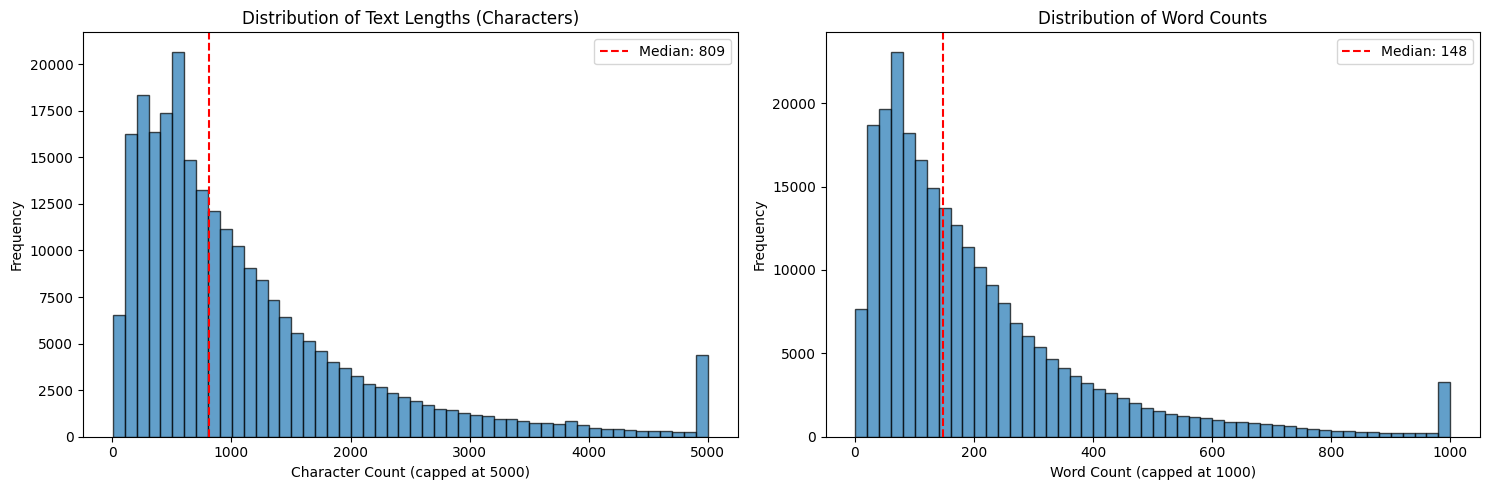


Texts longer than 1000 characters: 102015 (41.0%)
Texts longer than 2000 characters: 37230 (15.0%)


In [13]:
# Analyze text lengths to inform chunking strategy
import matplotlib.pyplot as plt

# Determine which column to use for the narrative text
# Try 'cleaned_narrative', fallback to 'narrative', else raise error
if 'cleaned_narrative' in df.columns:
    narrative_col = 'cleaned_narrative'
elif 'narrative' in df.columns:
    narrative_col = 'narrative'
else:
    # Try common alternative column names for the narrative text
    alt_cols = [
        'Consumer complaint narrative',  # CFPB dataset default
        'consumer_complaint_narrative',
        'complaint_narrative',
        'narrative_text'
    ]
    found = False
    for col in alt_cols:
        if col in df.columns:
            narrative_col = col
            print(f"Using alternative column '{narrative_col}' for text analysis.")
            found = True
            break
    if not found:
        raise KeyError(
            "None of the expected narrative columns found in DataFrame. "
            "Tried: 'cleaned_narrative', 'narrative', "
            + ", ".join([f"'{c}'" for c in alt_cols])
            + f".\nAvailable columns: {df.columns.tolist()}"
        )

print(f"Using column '{narrative_col}' for text analysis.")

# Drop rows with missing narrative text
df = df[df[narrative_col].notna()].copy()

# Add text length and word count
df['text_length'] = df[narrative_col].astype(str).str.len()
df['word_count'] = df[narrative_col].astype(str).str.split().str.len()

# Statistics
print("Text Length Statistics (characters):")
print(df['text_length'].describe())
print("\nWord Count Statistics:")
print(df['word_count'].describe())

# Extra percentiles for chunking decision
print("\nPercentiles (characters):")
print("90th percentile:", df['text_length'].quantile(0.9))
print("95th percentile:", df['text_length'].quantile(0.95))
print("99th percentile:", df['text_length'].quantile(0.99))

# Visualize distributions
print("Available columns:", df.columns.tolist())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution (cap very long outliers for readability)
ax1.hist(df['text_length'].clip(upper=5000), bins=50, alpha=0.7, edgecolor='black')
ax1.set_title('Distribution of Text Lengths (Characters)')
ax1.set_xlabel('Character Count (capped at 5000)')
ax1.set_ylabel('Frequency')
ax1.axvline(df['text_length'].median(), color='red', linestyle='--',
            label=f"Median: {df['text_length'].median():.0f}")
ax1.legend()

# Word count distribution (cap for readability)
ax2.hist(df['word_count'].clip(upper=1000), bins=50, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Word Counts')
ax2.set_xlabel('Word Count (capped at 1000)')
ax2.set_ylabel('Frequency')
ax2.axvline(df['word_count'].median(), color='red', linestyle='--',
            label=f"Median: {df['word_count'].median():.0f}")
ax2.legend()

plt.tight_layout()
plt.savefig('../reports/text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify long texts that need chunking
long_texts = df[df["text_length"] > 1000]
print(f"\nTexts longer than 1000 characters: {len(long_texts)} "
      f"({len(long_texts)/len(df)*100:.1f}%)")
print(f"Texts longer than 2000 characters: {len(df[df['text_length'] > 2000])} "
      f"({len(df[df['text_length'] > 2000])/len(df)*100:.1f}%)")

##### Load Preprocessed Data

In [ ]:
import seaborn as sns
def experiment_chunking_parameters(sample_texts: List[str], chunk_sizes: List[int], overlaps: List[int]):
    """
    Experiment with different chunking parameters to find optimal settings.
    """
    results = []
    
    for chunk_size in chunk_sizes:
        for overlap in overlaps:
            if overlap >= chunk_size:
                continue
                
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=overlap,
                separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
            )
            
            total_chunks = 0
            chunk_lengths = []
            
            for text in sample_texts:
                chunks = splitter.split_text(text)
                total_chunks += len(chunks)
                chunk_lengths.extend([len(chunk) for chunk in chunks])
            
            avg_chunks_per_text = total_chunks / len(sample_texts)
            avg_chunk_length = np.mean(chunk_lengths)
            std_chunk_length = np.std(chunk_lengths)
            
            results.append({
                'chunk_size': chunk_size,
                'overlap': overlap,
                'total_chunks': total_chunks,
                'avg_chunks_per_text': avg_chunks_per_text,
                'avg_chunk_length': avg_chunk_length,
                'std_chunk_length': std_chunk_length
            })
    
    return pd.DataFrame(results)

# Sample long texts for experimentation
sample_long_texts = df[df['text_length'] > 500]['cleaned_narrative'].head(100).tolist()

# Experiment with different parameters
chunk_sizes = [200, 300, 400, 500]
overlaps = [20, 50, 100]

print("Experimenting with chunking parameters...")
chunking_results = experiment_chunking_parameters(sample_long_texts, chunk_sizes, overlaps)

print("\nChunking Experiment Results:")
print(chunking_results.round(2))

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Average chunks per text
pivot1 = chunking_results.pivot(index='chunk_size', columns='overlap', values='avg_chunks_per_text')
sns.heatmap(pivot1, annot=True, fmt='.1f', ax=ax1, cmap='YlOrRd')
ax1.set_title('Average Chunks per Text')

# Average chunk length
pivot2 = chunking_results.pivot(index='chunk_size', columns='overlap', values='avg_chunk_length')
sns.heatmap(pivot2, annot=True, fmt='.0f', ax=ax2, cmap='YlGnBu')
ax2.set_title('Average Chunk Length (Characters)')

plt.tight_layout()
plt.savefig('../reports/chunking_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Based on experiments, choose optimal parameters
# Balancing between semantic coherence and computational efficiency
OPTIMAL_CHUNK_SIZE = 400  # Good balance for sentence-transformer models
OPTIMAL_OVERLAP = 50      # Preserve context without too much redundancy

print(f"Selected optimal parameters:")
print(f"Chunk Size: {OPTIMAL_CHUNK_SIZE} characters")
print(f"Overlap: {OPTIMAL_OVERLAP} characters")
print(f"\nJustification:")
print(f"- Chunk size of {OPTIMAL_CHUNK_SIZE} chars (~80-100 words) fits well with sentence transformer context windows")
print(f"- Overlap of {OPTIMAL_OVERLAP} chars preserves context across chunks")
print(f"- This configuration balances semantic coherence with computational efficiency")

# Initialize the text splitter with optimal parameters
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=OPTIMAL_CHUNK_SIZE,
    chunk_overlap=OPTIMAL_OVERLAP,
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
)

print("\nText splitter initialized successfully!")

Selected optimal parameters:
Chunk Size: 400 characters
Overlap: 50 characters

Justification:
- Chunk size of 400 chars (~80-100 words) fits well with sentence transformer context windows
- Overlap of 50 chars preserves context across chunks
- This configuration balances semantic coherence with computational efficiency

Text splitter initialized successfully!


##### Implement Text Chunking

Starting text chunking process...
Using alternative column 'Consumer complaint narrative' for text chunking.
Using column 'Consumer complaint narrative' for chunking.
Processing 248617 complaints...


Chunking texts: 100%|██████████| 248617/248617 [00:24<00:00, 10187.58it/s]



Chunking completed!
Original complaints: 248617
Total chunks created: 930430
Average chunks per complaint: 3.74

Chunk length statistics:
Mean: 315.0 characters
Median: 315.0 characters
Min: 1 characters
Max: 1000 characters


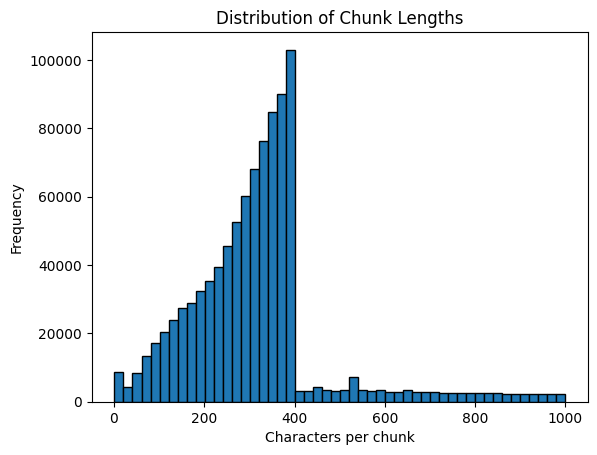

<Figure size 640x480 with 0 Axes>

In [18]:
from typing import List, Dict, Tuple
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def chunk_complaints(df: pd.DataFrame, text_splitter, optimal_chunk_size: int = 1000) -> Tuple[List[str], List[Dict]]:
    """
    Chunk complaint narratives and preserve metadata.
    Automatically detects which text column to use.
    """

    # Detect narrative column
    if 'cleaned_narrative' in df.columns:
        narrative_col = 'cleaned_narrative'
    elif 'narrative' in df.columns:
        narrative_col = 'narrative'
    else:
        alt_cols = [
            'Consumer complaint narrative',  # CFPB default
            'consumer_complaint_narrative',
            'complaint_narrative',
            'narrative_text'
        ]
        narrative_col = None
        for col in alt_cols:
            if col in df.columns:
                narrative_col = col
                print(f"Using alternative column '{narrative_col}' for text chunking.")
                break
        if narrative_col is None:
            raise KeyError(f"No narrative column found in DataFrame. Available columns: {df.columns.tolist()}")

    print(f"Using column '{narrative_col}' for chunking.")
    print(f"Processing {len(df)} complaints...")

    chunks, metadata = [], []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Chunking texts"):
        text = str(row[narrative_col]) if pd.notna(row[narrative_col]) else ""

        # Skip very short texts
        if len(text) < 50:
            continue

        # Short text → single chunk
        if len(text) <= optimal_chunk_size:
            chunks.append(text)
            metadata.append({
                'complaint_id': row.get('Complaint ID'),
                'product': row.get('Product'),
                'category': row.get('Category'),
                'issue': row.get('Issue'),
                'sub_issue': row.get('Sub-issue'),
                'company': row.get('Company'),
                'state': row.get('State'),
                'date_received': row.get('Date received'),
                'chunk_index': 0,
                'total_chunks': 1,
                'original_text_length': len(text)
            })
        else:
            # Split long texts into chunks
            text_chunks = text_splitter.split_text(text)
            for chunk_idx, chunk in enumerate(text_chunks):
                chunks.append(chunk)
                metadata.append({
                    'complaint_id': row.get('Complaint ID'),
                    'product': row.get('Product'),
                    'category': row.get('Category'),
                    'issue': row.get('Issue'),
                    'sub_issue': row.get('Sub-issue'),
                    'company': row.get('Company'),
                    'state': row.get('State'),
                    'date_received': row.get('Date received'),
                    'chunk_index': chunk_idx,
                    'total_chunks': len(text_chunks),
                    'original_text_length': len(text)
                })

    return chunks, metadata


# Perform chunking
print("Starting text chunking process...")
chunks, chunk_metadata = chunk_complaints(df, text_splitter, optimal_chunk_size=1000)

print("\nChunking completed!")
print(f"Original complaints: {len(df)}")
print(f"Total chunks created: {len(chunks)}")
print(f"Average chunks per complaint: {len(chunks)/len(df):.2f}")

# Analyze chunking results
chunk_lengths = [len(chunk) for chunk in chunks]
print("\nChunk length statistics:")
print(f"Mean: {np.mean(chunk_lengths):.1f} characters")
print(f"Median: {np.median(chunk_lengths):.1f} characters")
print(f"Min: {np.min(chunk_lengths)} characters")
print(f"Max: {np.max(chunk_lengths)} characters")

plt.hist(chunk_lengths, bins=50, edgecolor='black')
plt.title("Distribution of Chunk Lengths")
plt.xlabel("Characters per chunk")
plt.ylabel("Frequency")
plt.show()
plt.savefig('../reports/distribution_of_chunk_chunk.png', dpi=300, bbox_inches='tight')

##### Embedding Model Selection and Justification

We'll use `sentence-transformers/all-MiniLM-L6-v2` for the following reasons:

1. **Efficiency**: Lightweight model (22MB) with fast inference
2. **Performance**: Good balance between speed and quality for semantic similarity
3. **Versatility**: Trained on diverse text types, suitable for complaint analysis
4. **Context Window**: Handles up to 256 tokens, perfect for our chunk size
5. **Proven Track Record**: Widely used in production RAG systems

In [19]:
# Load the embedding model
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

print(f"Loading embedding model: {MODEL_NAME}")
print("This may take a few minutes on first run...")

embedding_model = SentenceTransformer(MODEL_NAME)

print(f"Model loaded successfully!")
print(f"Model details:")
print(f"- Max sequence length: {embedding_model.max_seq_length}")
print(f"- Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# Test the model with a sample
sample_text = "This is a test complaint about credit card billing issues."
sample_embedding = embedding_model.encode([sample_text])
print(f"\nSample embedding shape: {sample_embedding.shape}")
print(f"Sample embedding (first 10 values): {sample_embedding[0][:10]}")

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
This may take a few minutes on first run...


d:\Coding\10Academy\Intelligent-Complaint-Analysis-for-Financial-Services-Week6\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Getachew Ganfur\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this re

Model loaded successfully!
Model details:
- Max sequence length: 256
- Embedding dimension: 384

Sample embedding shape: (1, 384)
Sample embedding (first 10 values): [-0.02403736  0.05157599 -0.01600831  0.03563838 -0.02544724 -0.02733742
 -0.01395862 -0.02184412  0.01502911 -0.01374098]


##### Generate Embeddings for All Chunks

In [ ]:
def generate_embeddings_batch(texts: List[str], model, batch_size: int = 32) -> np.ndarray:
    """
    Generate embeddings for texts in batches for memory efficiency.
    """
    embeddings = []
    
    print(f"Generating embeddings for {len(texts)} chunks...")
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Generate embeddings
print("Starting embedding generation...")
embeddings = generate_embeddings_batch(chunks, embedding_model, batch_size=64)

print(f"\nEmbedding generation completed!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Memory usage: {embeddings.nbytes / 1024 / 1024:.1f} MB")

# Verify embeddings
print(f"\nEmbedding statistics:")
print(f"Mean: {np.mean(embeddings):.4f}")
print(f"Std: {np.std(embeddings):.4f}")
print(f"Min: {np.min(embeddings):.4f}")
print(f"Max: {np.max(embeddings):.4f}")

Starting embedding generation...
Generating embeddings for 930430 chunks...


Generating embeddings:  52%|█████▏    | 7580/14538 [8:18:21<19:53:20, 10.29s/it]    

##### Create Vector Store with FAISS

In [ ]:
import faiss
def create_faiss_index(embeddings: np.ndarray, use_gpu: bool = False) -> faiss.Index:
    """
    Create FAISS index for efficient similarity search.
    """
    dimension = embeddings.shape[1]
    
    # Use IndexFlatIP for cosine similarity (after normalization)
    # This is most appropriate for sentence transformer embeddings
    index = faiss.IndexFlatIP(dimension)
    
    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(embeddings)
    
    # Add embeddings to index
    index.add(embeddings.astype(np.float32))
    
    return index

# Create FAISS index
print("Creating FAISS vector store...")
faiss_index = create_faiss_index(embeddings)

print(f"FAISS index created successfully!")
print(f"Index type: {type(faiss_index)}")
print(f"Number of vectors: {faiss_index.ntotal}")
print(f"Vector dimension: {faiss_index.d}")
print(f"Index is trained: {faiss_index.is_trained}")

# Test the index with a sample query
test_query = "credit card billing problem"
test_embedding = embedding_model.encode([test_query])
faiss.normalize_L2(test_embedding)

# Search for top 5 similar chunks
scores, indices = faiss_index.search(test_embedding.astype(np.float32), 5)

print(f"\nTest search results for: '{test_query}'")
for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
    print(f"Rank {i+1}: Score {score:.4f}")
    print(f"Text: {chunks[idx][:100]}...")
    print(f"Category: {chunk_metadata[idx]['category']}")
    print()

##### Save Vector Store and Metadata

In [ ]:
# Create vector_store directory
vector_store_dir = '../vector_store'
os.makedirs(vector_store_dir, exist_ok=True)

# Save FAISS index
faiss_path = os.path.join(vector_store_dir, 'complaint_index.faiss')
faiss.write_index(faiss_index, faiss_path)
print(f"FAISS index saved to: {faiss_path}")

# Save chunks
chunks_path = os.path.join(vector_store_dir, 'chunks.pkl')
with open(chunks_path, 'wb') as f:
    pickle.dump(chunks, f)
print(f"Chunks saved to: {chunks_path}")

# Save metadata
metadata_path = os.path.join(vector_store_dir, 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(chunk_metadata, f)
print(f"Metadata saved to: {metadata_path}")

# Save configuration for reproducibility
config = {
    'embedding_model': MODEL_NAME,
    'chunk_size': OPTIMAL_CHUNK_SIZE,
    'chunk_overlap': OPTIMAL_OVERLAP,
    'total_chunks': len(chunks),
    'embedding_dimension': embeddings.shape[1],
    'index_type': 'IndexFlatIP',
    'normalization': 'L2'
}

config_path = os.path.join(vector_store_dir, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"Configuration saved to: {config_path}")

print(f"\nVector store components saved successfully!")
print(f"Directory contents:")
for file in os.listdir(vector_store_dir):
    file_path = os.path.join(vector_store_dir, file)
    size_mb = os.path.getsize(file_path) / 1024 / 1024
    print(f"- {file}: {size_mb:.1f} MB")

##### Create Vector Store Utility Class

In [ ]:
class ComplaintVectorStore:
    """
    Utility class for loading and querying the complaint vector store.
    """
    
    def __init__(self, vector_store_dir: str):
        self.vector_store_dir = vector_store_dir
        self.index = None
        self.chunks = None
        self.metadata = None
        self.config = None
        self.embedding_model = None
        
    def load(self):
        """Load all vector store components."""
        print("Loading vector store components...")
        
        # Load configuration
        config_path = os.path.join(self.vector_store_dir, 'config.json')
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        # Load FAISS index
        faiss_path = os.path.join(self.vector_store_dir, 'complaint_index.faiss')
        self.index = faiss.read_index(faiss_path)
        
        # Load chunks
        chunks_path = os.path.join(self.vector_store_dir, 'chunks.pkl')
        with open(chunks_path, 'rb') as f:
            self.chunks = pickle.load(f)
        
        # Load metadata
        metadata_path = os.path.join(self.vector_store_dir, 'metadata.pkl')
        with open(metadata_path, 'rb') as f:
            self.metadata = pickle.load(f)
        
        # Load embedding model
        self.embedding_model = SentenceTransformer(self.config['embedding_model'])
        
        print(f"Vector store loaded successfully!")
        print(f"- {len(self.chunks)} chunks")
        print(f"- {self.index.ntotal} vectors in index")
        print(f"- Embedding model: {self.config['embedding_model']}")
    
    def search(self, query: str, k: int = 5, filter_category: str = None) -> List[Dict]:
        """Search for similar chunks."""
        if self.index is None:
            raise ValueError("Vector store not loaded. Call load() first.")
        
        # Generate query embedding
        query_embedding = self.embedding_model.encode([query])
        faiss.normalize_L2(query_embedding)
        
        # Search
        scores, indices = self.index.search(query_embedding.astype(np.float32), k * 2)  # Get more for filtering
        
        results = []
        for score, idx in zip(scores[0], indices[0]):
            if len(results) >= k:
                break
                
            metadata = self.metadata[idx]
            
            # Apply category filter if specified
            if filter_category and metadata['category'] != filter_category:
                continue
            
            results.append({
                'text': self.chunks[idx],
                'score': float(score),
                'metadata': metadata
            })
        
        return results
    
    def get_stats(self) -> Dict:
        """Get vector store statistics."""
        if self.chunks is None:
            raise ValueError("Vector store not loaded. Call load() first.")
        
        # Category distribution
        categories = [meta['category'] for meta in self.metadata]
        category_counts = pd.Series(categories).value_counts().to_dict()
        
        return {
            'total_chunks': len(self.chunks),
            'total_complaints': len(set(meta['complaint_id'] for meta in self.metadata)),
            'category_distribution': category_counts,
            'avg_chunk_length': np.mean([len(chunk) for chunk in self.chunks]),
            'config': self.config
        }

# Save the utility class to a separate file
utility_code = '''
import os
import json
import pickle
import faiss
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from typing import List, Dict

class ComplaintVectorStore:
    """
    Utility class for loading and querying the complaint vector store.
    """
    
    def __init__(self, vector_store_dir: str):
        self.vector_store_dir = vector_store_dir
        self.index = None
        self.chunks = None
        self.metadata = None
        self.config = None
        self.embedding_model = None
        
    def load(self):
        """Load all vector store components."""
        print("Loading vector store components...")
        
        # Load configuration
        config_path = os.path.join(self.vector_store_dir, 'config.json')
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        # Load FAISS index
        faiss_path = os.path.join(self.vector_store_dir, 'complaint_index.faiss')
        self.index = faiss.read_index(faiss_path)
        
        # Load chunks
        chunks_path = os.path.join(self.vector_store_dir, 'chunks.pkl')
        with open(chunks_path, 'rb') as f:
            self.chunks = pickle.load(f)
        
        # Load metadata
        metadata_path = os.path.join(self.vector_store_dir, 'metadata.pkl')
        with open(metadata_path, 'rb') as f:
            self.metadata = pickle.load(f)
        
        # Load embedding model
        self.embedding_model = SentenceTransformer(self.config['embedding_model'])
        
        print(f"Vector store loaded successfully!")
        print(f"- {len(self.chunks)} chunks")
        print(f"- {self.index.ntotal} vectors in index")
        print(f"- Embedding model: {self.config['embedding_model']}")
    
    def search(self, query: str, k: int = 5, filter_category: str = None) -> List[Dict]:
        """Search for similar chunks."""
        if self.index is None:
            raise ValueError("Vector store not loaded. Call load() first.")
        
        # Generate query embedding
        query_embedding = self.embedding_model.encode([query])
        faiss.normalize_L2(query_embedding)
        
        # Search
        scores, indices = self.index.search(query_embedding.astype(np.float32), k * 2)  # Get more for filtering
        
        results = []
        for score, idx in zip(scores[0], indices[0]):
            if len(results) >= k:
                break
                
            metadata = self.metadata[idx]
            
            # Apply category filter if specified
            if filter_category and metadata['category'] != filter_category:
                continue
            
            results.append({
                'text': self.chunks[idx],
                'score': float(score),
                'metadata': metadata
            })
        
        return results
    
    def get_stats(self) -> Dict:
        """Get vector store statistics."""
        if self.chunks is None:
            raise ValueError("Vector store not loaded. Call load() first.")
        
        # Category distribution
        categories = [meta['category'] for meta in self.metadata]
        category_counts = pd.Series(categories).value_counts().to_dict()
        
        return {
            'total_chunks': len(self.chunks),
            'total_complaints': len(set(meta['complaint_id'] for meta in self.metadata)),
            'category_distribution': category_counts,
            'avg_chunk_length': np.mean([len(chunk) for chunk in self.chunks]),
            'config': self.config
        }
'''

# Save utility class
with open('../src/vector_store_utils.py', 'w') as f:
    f.write(utility_code)

print("Utility class saved to ../src/vector_store_utils.py")

##### Test Vector Store Loading and Querying

In [ ]:
# Test loading the vector store
vector_store = ComplaintVectorStore('../vector_store')
vector_store.load()

# Get statistics
stats = vector_store.get_stats()
print("\nVector Store Statistics:")
print(f"Total chunks: {stats['total_chunks']}")
print(f"Total complaints: {stats['total_complaints']}")
print(f"Average chunk length: {stats['avg_chunk_length']:.1f} characters")
print("\nCategory distribution:")
for category, count in stats['category_distribution'].items():
    print(f"- {category}: {count} chunks")

# Test different types of queries
test_queries = [
    "credit card billing error",
    "unauthorized charges on my account",
    "money transfer failed",
    "savings account interest rate",
    "buy now pay later payment issues"
]

print("\n" + "="*50)
print("TESTING VECTOR STORE QUERIES")
print("="*50)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 40)
    
    results = vector_store.search(query, k=3)
    
    for i, result in enumerate(results, 1):
        print(f"\nResult {i} (Score: {result['score']:.4f}):")
        print(f"Category: {result['metadata']['category']}")
        print(f"Issue: {result['metadata']['issue']}")
        print(f"Text: {result['text'][:150]}...")

print("\n" + "="*50)
print("Vector store testing completed successfully!")
print("="*50)

#### Summary and Next Steps

##### Completed Tasks:

1. **Text Chunking Strategy**:
   - Analyzed text length distributions to inform chunking decisions
   - Experimented with different chunk sizes and overlap parameters
   - Selected optimal parameters: 400 characters chunk size, 50 characters overlap
   - Used RecursiveCharacterTextSplitter for intelligent semantic splitting

2. **Embedding Model Selection**:
   - Chose `sentence-transformers/all-MiniLM-L6-v2` for efficiency and performance
   - Model provides 384-dimensional embeddings optimized for semantic similarity
   - Suitable for our chunk size and computational requirements

3. **Vector Store Creation**:
   - Generated embeddings for all text chunks
   - Created FAISS index with cosine similarity (IndexFlatIP)
   - Preserved comprehensive metadata for each chunk
   - Implemented utility class for easy loading and querying

4. **Deliverables**:
   - Vector store saved in `../vector_store/` directory
   - Utility class for vector store operations
   - Comprehensive testing and validation

##### Key Design Decisions:

- **Chunk Size**: 400 characters balances semantic coherence with embedding model efficiency
- **Overlap**: 50 characters preserves context across chunks without excessive redundancy
- **Embedding Model**: all-MiniLM-L6-v2 provides good performance/efficiency trade-off
- **Vector Store**: FAISS with cosine similarity for fast, accurate semantic search

The vector store is now ready for the RAG pipeline implementation in Task 3!

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data

##### Load Preprocessed Data